# CREATest Experiments for ICTSS 2025

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Data Setup

In [ ]:
# Read the CSV file
X = pd.read_csv('data/data.csv')

# Cast to int or float everything that should be a number
X['NumStates'] = X['NumStates'].astype(int)
X['AvgDepth'] = X['AvgDepth'].astype(float)
X['MaxDepth'] = X['MaxDepth'].astype(int)
X['StandardEvosuiteCoverage'] = X['StandardEvosuiteCoverage'].astype(float)
X['StandardSCTUnitCoverage'] = X['StandardSCTUnitCoverage'].astype(float)
X['SimplifiedEvosuiteCoverage'] = X['SimplifiedEvosuiteCoverage'].astype(float)
X['SimplifiedSCTUnitCoverage'] = X['SimplifiedSCTUnitCoverage'].astype(float)

## Generate SCTUnit Test Suite

In [83]:
'''
with open("__SimplifiedTestSuite.sctunit", "w") as f:
    print("testsuite SimplifiedTestSuite {", file=f)
    for idx, stc in enumerate(X['StatechartName']):
        print("\t"+stc+"SimplifiedTest", end="", file=f)
        if idx != len(X['StatechartName'])-1:
            print(",", file = f)
    print("\n}", file=f)

with open("__StandardTestSuite.sctunit", "w") as f:
    print("testsuite StandardTestSuite {", file=f)
    for idx, stc in enumerate(X['StatechartName']):
        print("\t"+stc+"Test", end="", file=f)
        if idx != len(X['StatechartName'])-1:
            print(",", file = f)
    print("\n}", file=f)
'''

'\nwith open("__SimplifiedTestSuite.sctunit", "w") as f:\n    print("testsuite SimplifiedTestSuite {", file=f)\n    for idx, stc in enumerate(X[\'StatechartName\']):\n        print("\t"+stc+"SimplifiedTest", end="", file=f)\n        if idx != len(X[\'StatechartName\'])-1:\n            print(",", file = f)\n    print("\n}", file=f)\n\nwith open("__StandardTestSuite.sctunit", "w") as f:\n    print("testsuite StandardTestSuite {", file=f)\n    for idx, stc in enumerate(X[\'StatechartName\']):\n        print("\t"+stc+"Test", end="", file=f)\n        if idx != len(X[\'StatechartName\'])-1:\n            print(",", file = f)\n    print("\n}", file=f)\n'

## Read Numerical Information

In [84]:
standard = len(X)
standardPassed = len(X[X['StandardSCTUnitStatus'] == 'PASSED'])
standardFailed = len(X[X['StandardSCTUnitStatus'] == 'FAILED'])
standardErrors = len(X[X['StandardSCTUnitStatus'] == 'ERROR'])
standardNotGenerated = len(X[X['StandardSCTUnitStatus'] == 'NOT GENERATED'])
standardBlocked = len(X[X['StandardSCTUnitStatus'] == 'BLOCKED'])

simplified = len(X)
simplifiedPassed = len(X[X['SimplifiedSCTUnitStatus'] == 'PASSED'])
simplifiedFailed = len(X[X['SimplifiedSCTUnitStatus'] == 'FAILED'])
simplifiedErrors = len(X[X['SimplifiedSCTUnitStatus'] == 'ERROR'])
simplifiedNotGenerated = len(X[X['SimplifiedSCTUnitStatus'] == 'NOT GENERATED'])
simplifiedBlocked = len(X[X['SimplifiedSCTUnitStatus'] == 'BLOCKED'])

# Collecting general data
print(f"Standard statechars ({standard} total)")
print(f"->Mean SCTUnit coverage: {statistics.mean(X['StandardSCTUnitCoverage'])}")
print(f"->Num. SCTUnit classes that passed: {standardPassed}")
print(f"->Num. SCTUnit classes that failed: {standardFailed}")
print(f"->Num. SCTUnit classes with errors: {standardErrors}")
print(f"->Num. SCTUnit classes not generated: {standardNotGenerated}")
print(f"->Num. SCTUnit classes blocked: {standardBlocked}")

# Collecting general data
print(f"Simplified statechars ({simplified} total)")
print(f"->Mean SCTUnit coverage: {statistics.mean(X['SimplifiedSCTUnitCoverage'])}")
print(f"->Num. SCTUnit classes that passed: {simplifiedPassed}")
print(f"->Num. SCTUnit classes that failed: {simplifiedFailed}")
print(f"->Num. SCTUnit classes with errors: {simplifiedErrors}")
print(f"->Num. SCTUnit classes not generated: {simplifiedNotGenerated}")
print(f"->Num. SCTUnit classes blocked: {simplifiedBlocked}")

Standard statechars (133 total)
->Mean SCTUnit coverage: 0.1924812030075188
->Num. SCTUnit classes that passed: 98
->Num. SCTUnit classes that failed: 29
->Num. SCTUnit classes with errors: 4
->Num. SCTUnit classes not generated: 0
->Num. SCTUnit classes blocked: 2
Simplified statechars (133 total)
->Mean SCTUnit coverage: 0.620375939849624
->Num. SCTUnit classes that passed: 125
->Num. SCTUnit classes that failed: 4
->Num. SCTUnit classes with errors: 1
->Num. SCTUnit classes not generated: 0
->Num. SCTUnit classes blocked: 3


In [ ]:
# Dropping irrelevant rows where 'SimplifiedSCTUnitStatus' is not 'PASSED' or 'FAILED'
X = X[(X['SimplifiedSCTUnitStatus'] != 'BLOCKED')]

In [85]:
# Calculating correlation coefficient
correlation = X['SimplifiedEvosuiteCoverage'].corr(X['SimplifiedSCTUnitCoverage'])
print(f"Correlation coefficient between SimplifiedEvosuiteCoverage and SimplifiedSCTUnitCoverage: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['NumStates'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and NumStates: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['AvgDepth'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and AvgDepth: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['MaxDepth'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and MaxDepth: {correlation}")

Correlation coefficient between SimplifiedEvosuiteCoverage and SimplifiedSCTUnitCoverage: 0.8282567501151874
Correlation coefficient between SimplifiedSCTUnitCoverage and NumStates: -0.5065830748094645
Correlation coefficient between SimplifiedSCTUnitCoverage and AvgDepth: -0.40682517704110027
Correlation coefficient between SimplifiedSCTUnitCoverage and MaxDepth: -0.4032550839229882


## Clustering

In [86]:
# Drop columns that are useless for clustering
drop_features = [
    'StandardEvosuiteCoverage', 
    'StandardSCTUnitCoverage', 
    'StandardSCTUnitStatus', 
    'SimplifiedEvosuiteCoverage', 
    'SimplifiedSCTUnitStatus'
]
X = X.drop(drop_features, axis=1)

# Specify the columns you want to scale
columns_to_scale = ['NumStates', 'AvgDepth', 'MaxDepth']  # replace with your column names

# Create a copy of the DataFrame to avoid modifying the original
X_scaled = X.copy()

# Scale the specified columns
scaler = StandardScaler()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [87]:
# Apply the OPTICS algorithm using the scaled columns
optics_model = OPTICS(xi=0.1, min_cluster_size=10, min_samples=4)
optics_model.fit(X_scaled[columns_to_scale])

# Apply the DBSCAN algorithm using the scaled columns
dbscan_model = DBSCAN(eps=0.55, min_samples=2)
dbscan_model.fit(X_scaled[columns_to_scale])

# Apply the KMeans algorithm using the scaled columns
kmeans_model = KMeans(n_clusters=4, random_state=0, n_init="auto")
kmeans_model.fit(X_scaled[columns_to_scale])

# Change labels according to improve readability a posteriori

for i in range(len(dbscan_model.labels_)):
    val = dbscan_model.labels_[i]
    if val == 0:
        dbscan_model.labels_[i] = 0
    elif val == 2:
        dbscan_model.labels_[i] = 1
    elif val == 1:
        dbscan_model.labels_[i] = 2
    elif val == 3:
        dbscan_model.labels_[i] = 3
    elif val == 4:
        dbscan_model.labels_[i] = 4

# Adding cluster labels to the original DataFrame
X['optics_label'] = optics_model.labels_
X['dbscan_label'] = dbscan_model.labels_
X['kmeans_label'] = kmeans_model.labels_

C:\Users\nico.pellegrinelli\AppData\Roaming\Python\Python313\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [88]:
# Calculate silhouette score for each model
silhouette_optics = silhouette_score(X_scaled[columns_to_scale], optics_model.labels_)
silhouette_dbscan = silhouette_score(X_scaled[columns_to_scale], dbscan_model.labels_)
silhouette_kmeans = silhouette_score(X_scaled[columns_to_scale], kmeans_model.labels_)
print("PREFERE HIGH SILHOUTTE")
print(f"Silhouette Score (OPTICS): {silhouette_optics}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")
print(f"Silhouette Score (KMeans): {silhouette_kmeans}")

# Calculate Davies-Bouldin index for each model
db_index_optics = davies_bouldin_score(X_scaled[columns_to_scale], optics_model.labels_)
db_index_dbscan = davies_bouldin_score(X_scaled[columns_to_scale], dbscan_model.labels_)
db_index_kmeans = davies_bouldin_score(X_scaled[columns_to_scale], kmeans_model.labels_)
print("PREFERE LOW DAVIES-BOULDIN INDEX")
print(f"Davies-Bouldin Index (OPTICS): {db_index_optics}")
print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")
print(f"Davies-Bouldin Index (KMeans): {db_index_kmeans}")

PREFERE HIGH SILHOUTTE
Silhouette Score (OPTICS): 0.13103909041319356
Silhouette Score (DBSCAN): 0.634928306895101
Silhouette Score (KMeans): 0.6283219966708644
PREFERE LOW DAVIES-BOULDIN INDEX
Davies-Bouldin Index (OPTICS): 1.257972418213628
Davies-Bouldin Index (DBSCAN): 0.748907065529863
Davies-Bouldin Index (KMeans): 0.599783301723406


In [89]:
# Number of outliers in DBSCAN and number of statecharts with max coverage
n_outliers = len(X[(X['dbscan_label'] == -1)])
print(f"\nNumbers of outliers in DBSCAN: {n_outliers}")
n_max_coverage = len(X[(X['SimplifiedSCTUnitCoverage'] == 1.00)])
print(f"Numbers of completely covered statecharts: {n_max_coverage}\n")


Numbers of outliers in DBSCAN: 5
Numbers of completely covered statecharts: 31



In [90]:
# Information about each cluster
print("CLUSTER 0")
cluster_0 = X[(X['dbscan_label'] ==  0)]
print(f"Mean coverage: {statistics.mean(cluster_0['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_0['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_0['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_0['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_0)}")
print(f"Max number of states: {max(cluster_0['NumStates'])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_0[(cluster_0['SimplifiedSCTUnitCoverage'] ==  1.00)])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_0[(cluster_0['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

print("CLUSTER 1")
cluster_1 = X[(X['dbscan_label'] ==  1)]
print(f"Mean coverage: {statistics.mean(cluster_1['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_1['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_1['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_1['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_1)}")
print(f"Max number of states: {max(cluster_1['NumStates'])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_1[(cluster_1['SimplifiedSCTUnitCoverage'] ==  1.00)])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_1[(cluster_1['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

print("CLUSTER 2")
cluster_2 = X[(X['dbscan_label'] ==  2)]
print(f"Mean coverage: {statistics.mean(cluster_2['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_2['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_2['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_2['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_2)}")
print(f"Max number of states: {max(cluster_2['NumStates'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_2[(cluster_2['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

print("CLUSTER 3")
cluster_3 = X[(X['dbscan_label'] ==  3)]
print(f"Mean coverage: {statistics.mean(cluster_3['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_3['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_3['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_3['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_3)}")
print(f"Max number of states: {max(cluster_3['NumStates'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_3[(cluster_3['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

print("CLUSTER 4")
cluster_4 = X[(X['dbscan_label'] ==  4)]
print(f"Mean coverage: {statistics.mean(cluster_4['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_4['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_4['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_4['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_4)}")
print(f"Max number of states: {max(cluster_4['NumStates'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_4[(cluster_4['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

print("CLUSTER -1")
cluster_m1 = X[(X['dbscan_label'] ==  -1)]
print(f"Mean coverage: {statistics.mean(cluster_m1['SimplifiedSCTUnitCoverage'])}")
print(f"Median coverage: {statistics.median(cluster_m1['SimplifiedSCTUnitCoverage'])}")
print(f"Mean NumStates: {statistics.mean(cluster_m1['NumStates'])}")
print(f"Mean AvgDepth: {statistics.mean(cluster_m1['AvgDepth'])}")
print(f"Number of statecharts: {len(cluster_m1)}")
print(f"Max number of states: {max(cluster_m1['NumStates'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_m1[(cluster_m1['SimplifiedSCTUnitCoverage'] ==  0.00)])}")

CLUSTER 0
Mean coverage: 0.7822916666666667
Median coverage: 0.895
Mean NumStates: 3.6041666666666665
Mean AvgDepth: 1.0
Number of statecharts: 48
Max number of states: 14
Number of statecharts with 100% coverage: 22
Number of statecharts with 0% coverage: 2
CLUSTER 1
Mean coverage: 0.6525714285714286
Median coverage: 0.8
Mean NumStates: 5.257142857142857
Mean AvgDepth: 1.5361224489795924
Number of statecharts: 35
Max number of states: 12
Number of statecharts with 100% coverage: 9
Number of statecharts with 0% coverage: 5
CLUSTER 2
Mean coverage: 0.5641666666666667
Median coverage: 0.64
Mean NumStates: 9.291666666666666
Mean AvgDepth: 2.0916539479039473
Number of statecharts: 24
Max number of states: 14
Number of statecharts with 0% coverage: 3
CLUSTER 3
Mean coverage: 0.23444444444444446
Median coverage: 0.0
Mean NumStates: 21.11111111111111
Mean AvgDepth: 2.2000386066175532
Number of statecharts: 9
Max number of states: 24
Number of statecharts with 0% coverage: 5
CLUSTER 4
Mean cov

## Plots

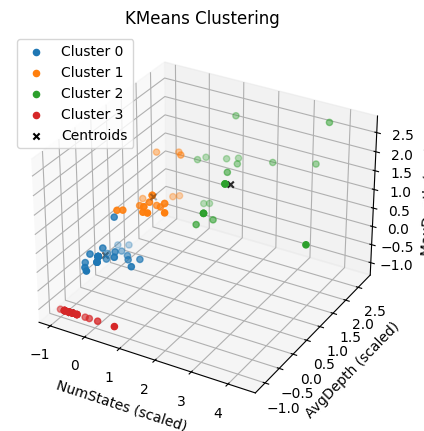

In [91]:
# Plot for KMeans 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in range(kmeans_model.n_clusters):
    cluster_mask = (kmeans_model.labels_ == cluster_label)
    ax.scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                X_scaled.loc[cluster_mask, 'AvgDepth'], 
                X_scaled.loc[cluster_mask, 'MaxDepth'], 
                label=f'Cluster {cluster_label}')
ax.scatter(kmeans_model.cluster_centers_[:, 0], 
            kmeans_model.cluster_centers_[:, 1], 
            kmeans_model.cluster_centers_[:, 2], 
            marker='x', color='black', label='Centroids')
ax.set_title('KMeans Clustering')
ax.set_xlabel('NumStates (scaled)')
ax.set_ylabel('AvgDepth (scaled)')
ax.set_zlabel('MaxDepth (scaled)')
ax.legend()

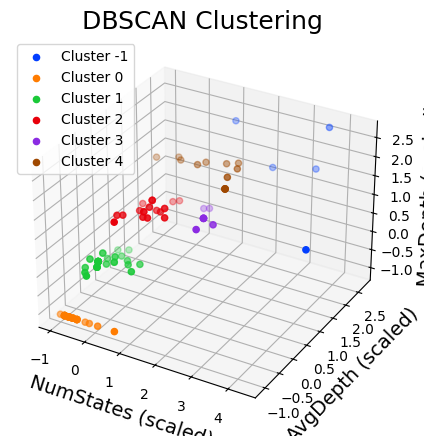

In [92]:
# Generate colors for each DBSCAN cluster
unique_labels = np.unique(dbscan_model.labels_)
colors = sns.color_palette('bright', len(unique_labels))

# Plot for DBSCAN in 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
for cluster_label, color in zip(unique_labels, colors):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    ax.scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                X_scaled.loc[cluster_mask, 'AvgDepth'], 
                X_scaled.loc[cluster_mask, 'MaxDepth'], 
                label=f'Cluster {cluster_label}', color=color)
ax.set_title('DBSCAN Clustering', fontsize=18)
ax.set_xlabel('NumStates (scaled)', fontsize=14)
ax.set_ylabel('AvgDepth (scaled)', fontsize=14)
ax.set_zlabel('MaxDepth (scaled)', fontsize=14)
ax.legend()

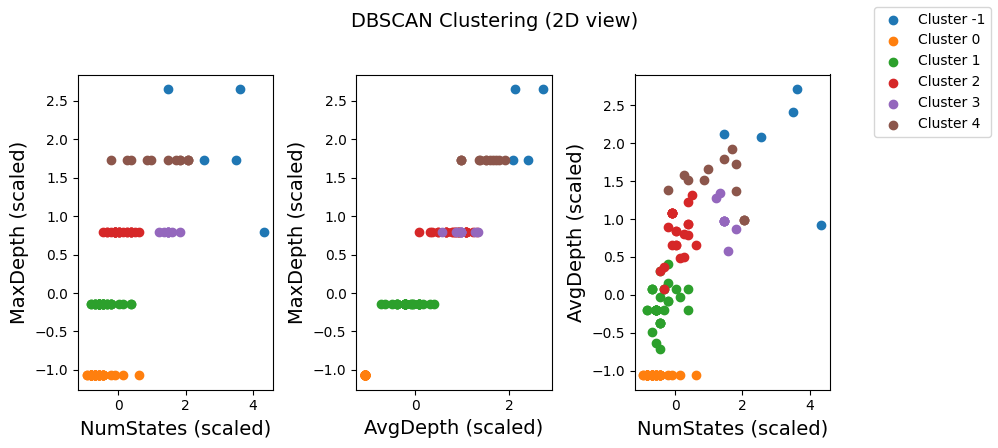

In [93]:
# Create subplots in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(10, 4.5))
fig.suptitle('DBSCAN Clustering (2D view)', fontsize=14)  # overall title

# --- Subplot 1: NumStates vs MaxDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[0].scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                   X_scaled.loc[cluster_mask, 'MaxDepth'], 
                   label=f'Cluster {cluster_label}')
axs[0].set_xlabel('NumStates (scaled)', fontsize=14)
axs[0].set_ylabel('MaxDepth (scaled)', fontsize=14)

# --- Subplot 2: AvgDepth vs MaxDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[1].scatter(X_scaled.loc[cluster_mask, 'AvgDepth'], 
                   X_scaled.loc[cluster_mask, 'MaxDepth'], 
                   label=f'Cluster {cluster_label}')
axs[1].set_xlabel('AvgDepth (scaled)', fontsize=14)
axs[1].set_ylabel('MaxDepth (scaled)', fontsize=14)

# --- Subplot 3: NumStates vs AvgDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[2].scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                   X_scaled.loc[cluster_mask, 'AvgDepth'], 
                   label=f'Cluster {cluster_label}')
axs[2].set_xlabel('NumStates (scaled)', fontsize=14)
axs[2].set_ylabel('AvgDepth (scaled)', fontsize=14)

# Create one overall legend using handles from the first subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

# Adjust layout so the overall title and legend are not overlapped
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show(block=False)


C:\Users\nico.pellegrinelli\AppData\Local\Temp\ipykernel_17884\1934073472.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dbscan_label', y='SimplifiedSCTUnitCoverage', data=X_sorted, palette=palette)


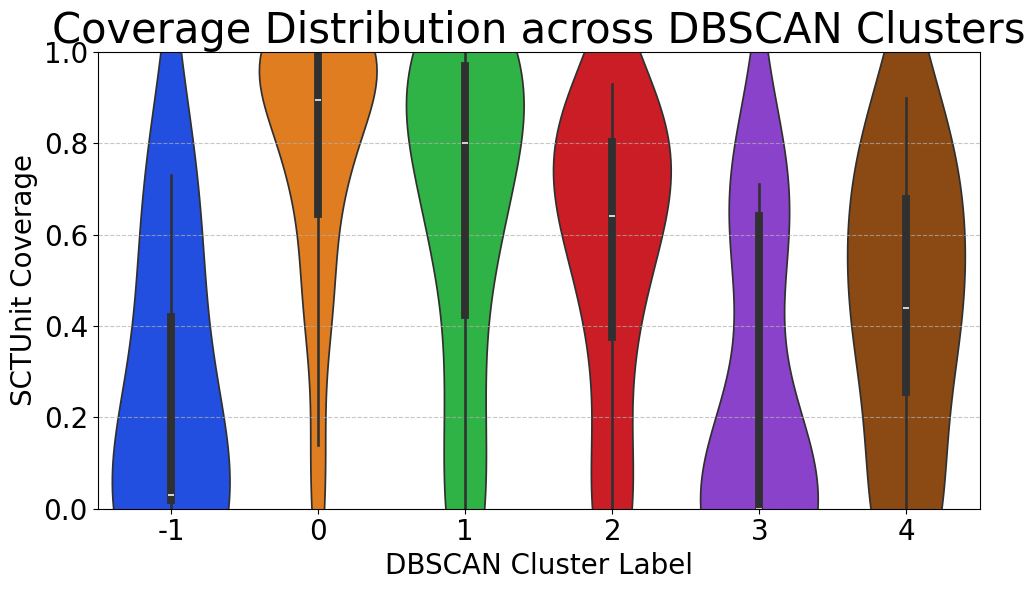

In [94]:
# Coverage Analysis for DBSCAN
# Analyze coverage within DBSCAN clusters
cluster_coverage_stats = X.groupby('dbscan_label')['SimplifiedSCTUnitCoverage'].describe()
# Create a custom color palette for the violin plot with string keys
palette = {str(label): color for label, color in zip(unique_labels, colors)}
# Sort the data by 'dbscan_label' in ascending order
X_sorted = X.sort_values(by='dbscan_label')
# Convert 'dbscan_label' to string type (for the palette)
X['dbscan_label'] = X['dbscan_label'].astype(str)
# Visualize coverage distribution within a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='dbscan_label', y='SimplifiedSCTUnitCoverage', data=X_sorted, palette=palette)
plt.ylim(0, 1)  # Limit y-axis from 0 to 1
plt.title('Coverage Distribution across DBSCAN Clusters', fontsize=30)
plt.xlabel('DBSCAN Cluster Label', fontsize=20)
plt.ylabel('SCTUnit Coverage', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
# Show plot
plt.tight_layout()
plt.show()